## Clustering the Countries by using Unsupervised Learning for HELP International

#### Objective:
To categorise the countries using socio-economic and health factors that determine the overall development of the country.

#### About organization:
HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities.

#### Problem Statement:
HELP International have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. So, CEO has to make decision to choose the countries that are in the direst need of aid. 

In [1]:
# supress warnings
import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

In [2]:
# import libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree


## Task 1: Reading and Inspection

-  ### Subtask 1.1 : Import and read

In [3]:
# reading data file
countries = pd.read_csv("Country-data.csv")
countries.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
countries.tail()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310
166,Zambia,83.1,37.0,5.89,30.9,3280,14.00,52.0,5.40,1460


-  ### Subtask 1.2 : Inspect the dataframe

In [5]:
countries.shape    # checking the size of dataframe

(167, 10)

In [6]:
countries.columns  # all the columns in the dataframe

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

In [7]:
countries.info()  # checking for variable data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


In [8]:
# checking if there is any spelling mistake in countries column
# or same country is repeated with different name
countries.country.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia',
       'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic',
       'Chad', 'Chile', 'China', 'Colombia', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire",
       'Croatia', 'Cyprus', 'Czech Republic', 'Denmark',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Fiji', 'Finland',
       'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana',
       'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau',
       'Guyana', 'Haiti', 'Hungary', 'Iceland', 'India', 'Indonesia',
       'Iran

**data looks ok. No spelling mistakes.**

In [9]:
# checking for missing values
countries.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

**we do not have any missing values.**

In [10]:
countries.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [11]:
# from data dictionary we can see that import , export and helth are given as percentage of 
# GDP per capita. 
# so in order to get correct statistical description of data we need to fix these values.

# for export 
countries["exports"] = round((countries["exports"] * countries["gdpp"]) / 100, 2)

# for health
countries["health"] = round((countries["health"] * countries["gdpp"]) / 100, 2)

# for impotrs
countries["imports"] = round((countries["imports"] * countries["gdpp"]) / 100, 2)

In [12]:
countries.head()  # checking for correct changes

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.90,1987.74,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.60,1514.37,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100,1.44,76.8,2.13,12200


In [13]:
# checking for statistical information
countries.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618862,1056.733174,6588.352096,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885789,1801.408921,14710.810423,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.080000,12.820000,0.650000,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535000,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.890000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,183750.000000,8663.600000,149100.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


## Task 2 : Exploratory Data Analysis

- ### Subtask 2.1 : Univariate Analysis

In [14]:
countries.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

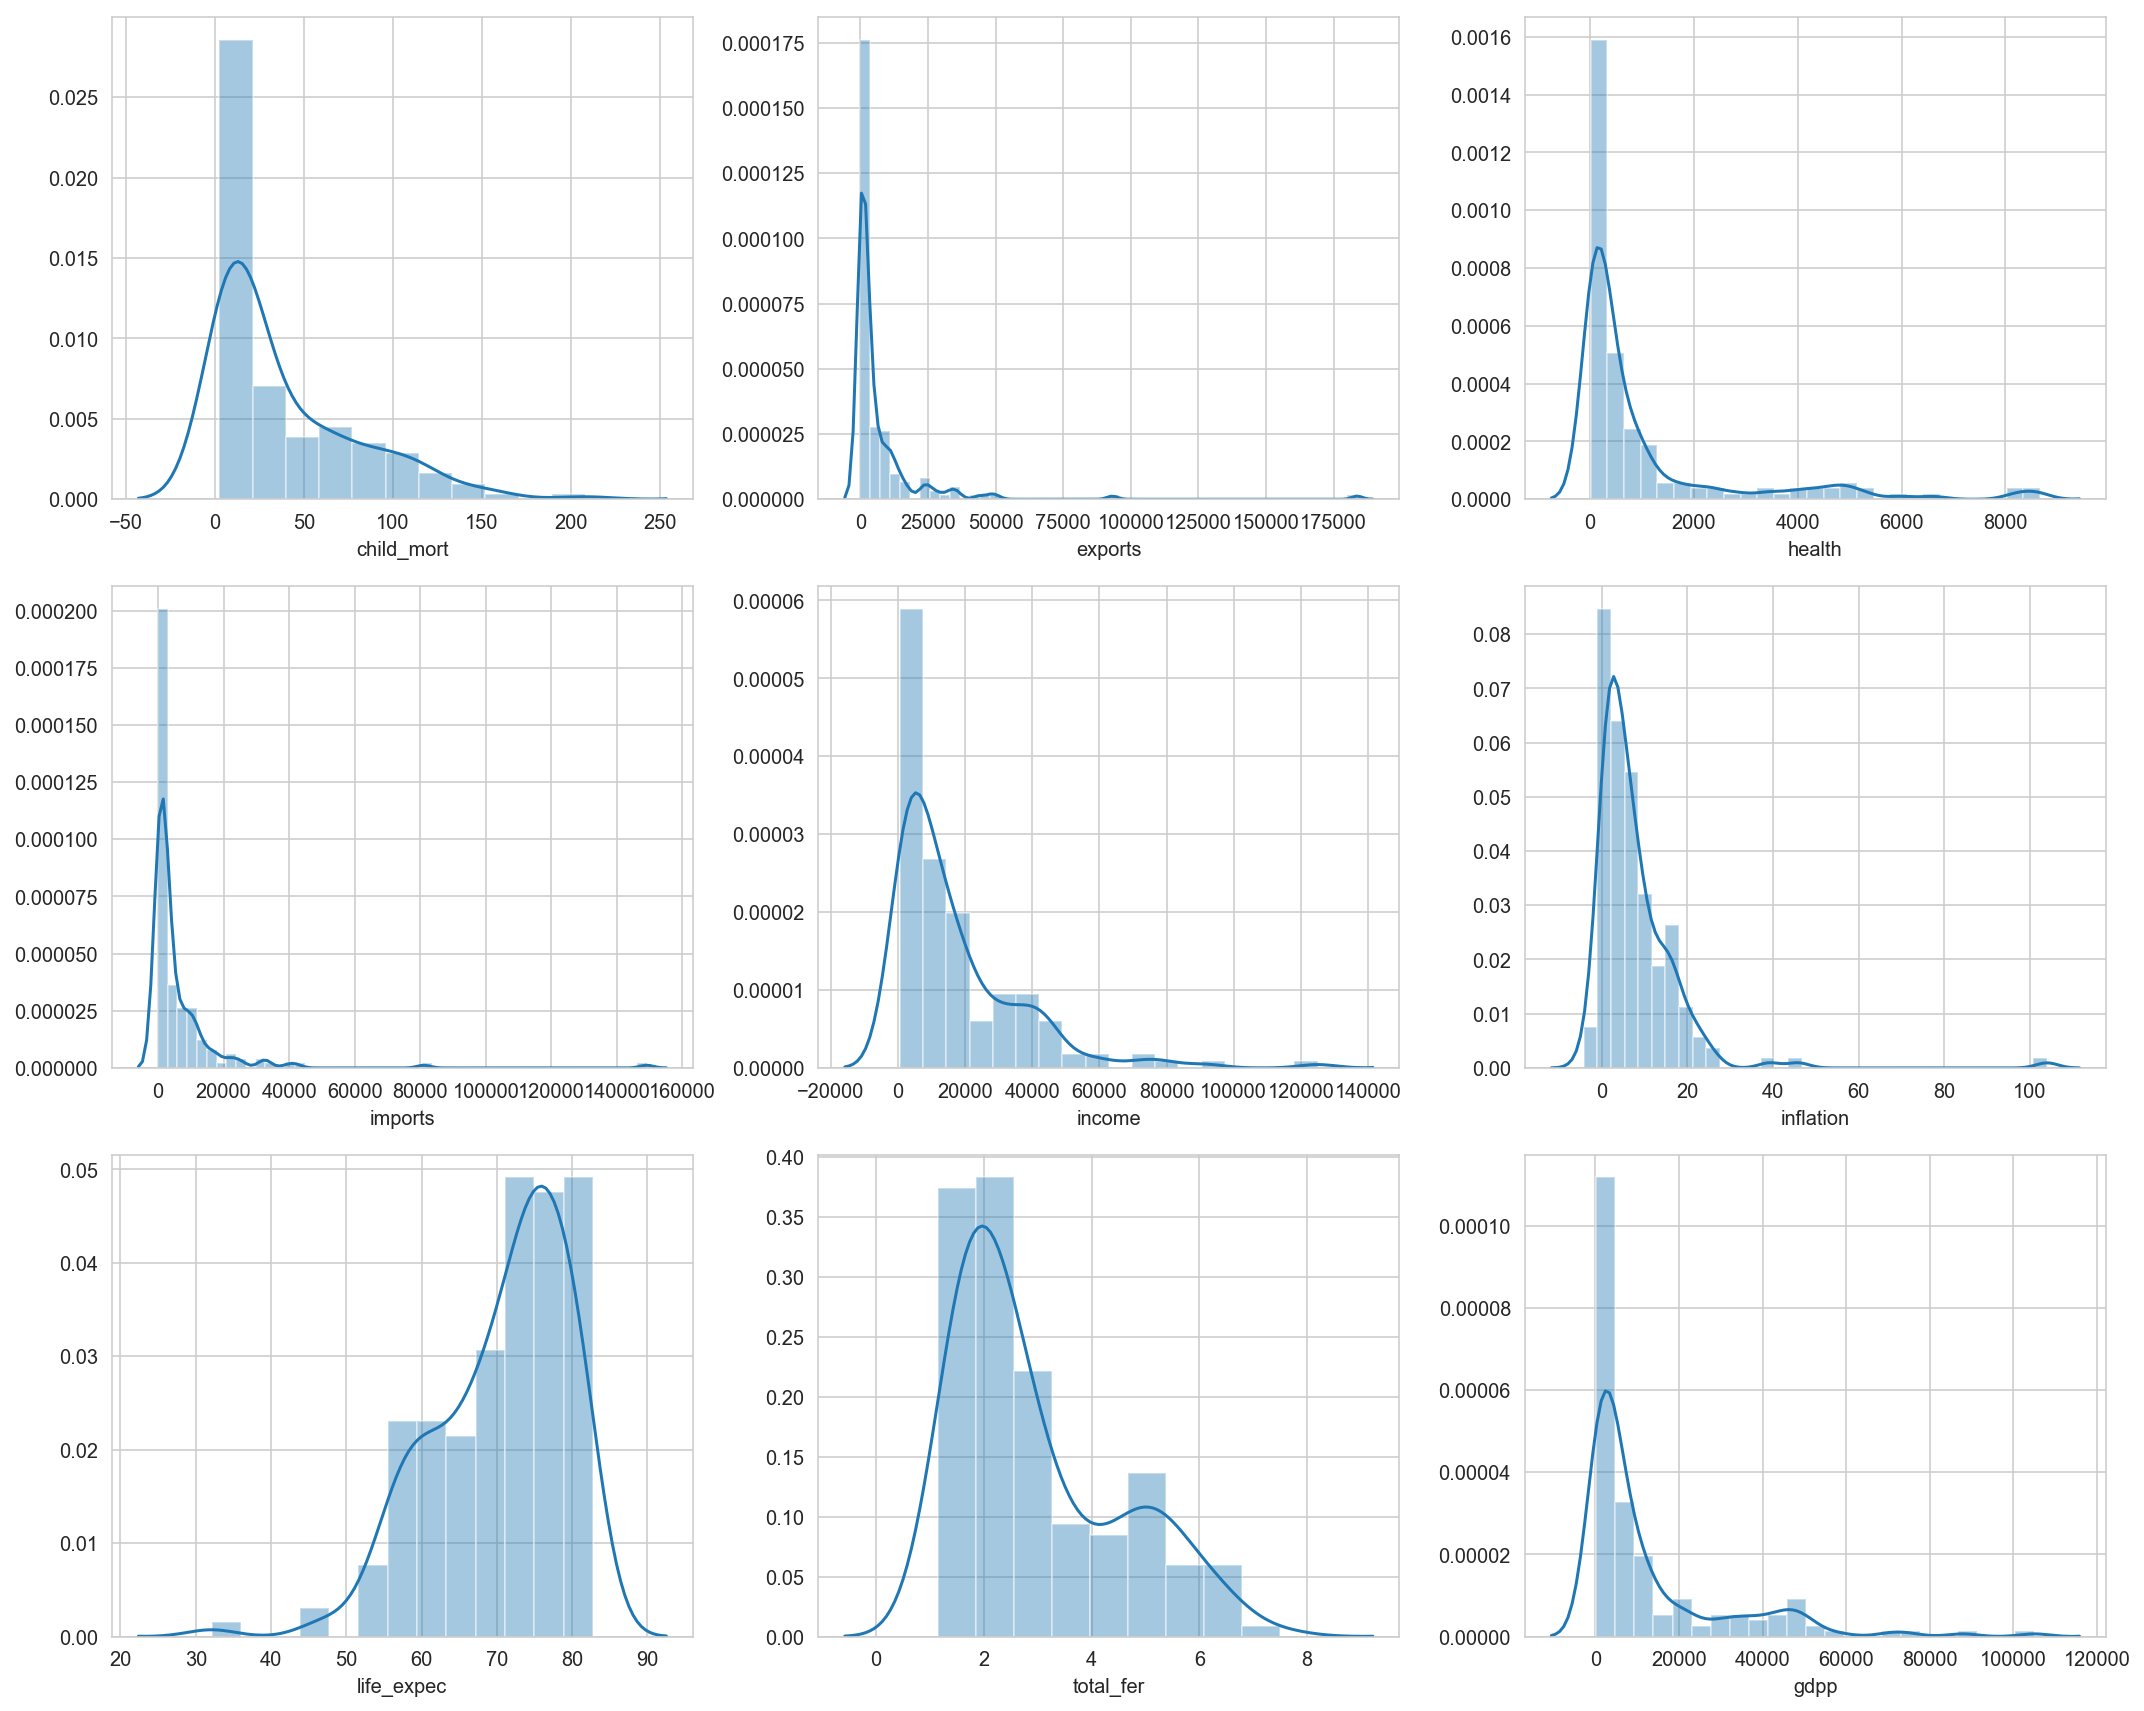

In [15]:
# lets check for data distribution using histogram
plt.figure(figsize=(15,12))
features = ['child_mort', 'exports', 'health', 'imports', 'income',
            'inflation', 'life_expec', 'total_fer', 'gdpp']

sns.set_style("whitegrid")

for i in enumerate(features):
    plt.subplot(3,3,i[0]+1)
    sns.distplot(countries[i[1]])

plt.tight_layout()
plt.show()

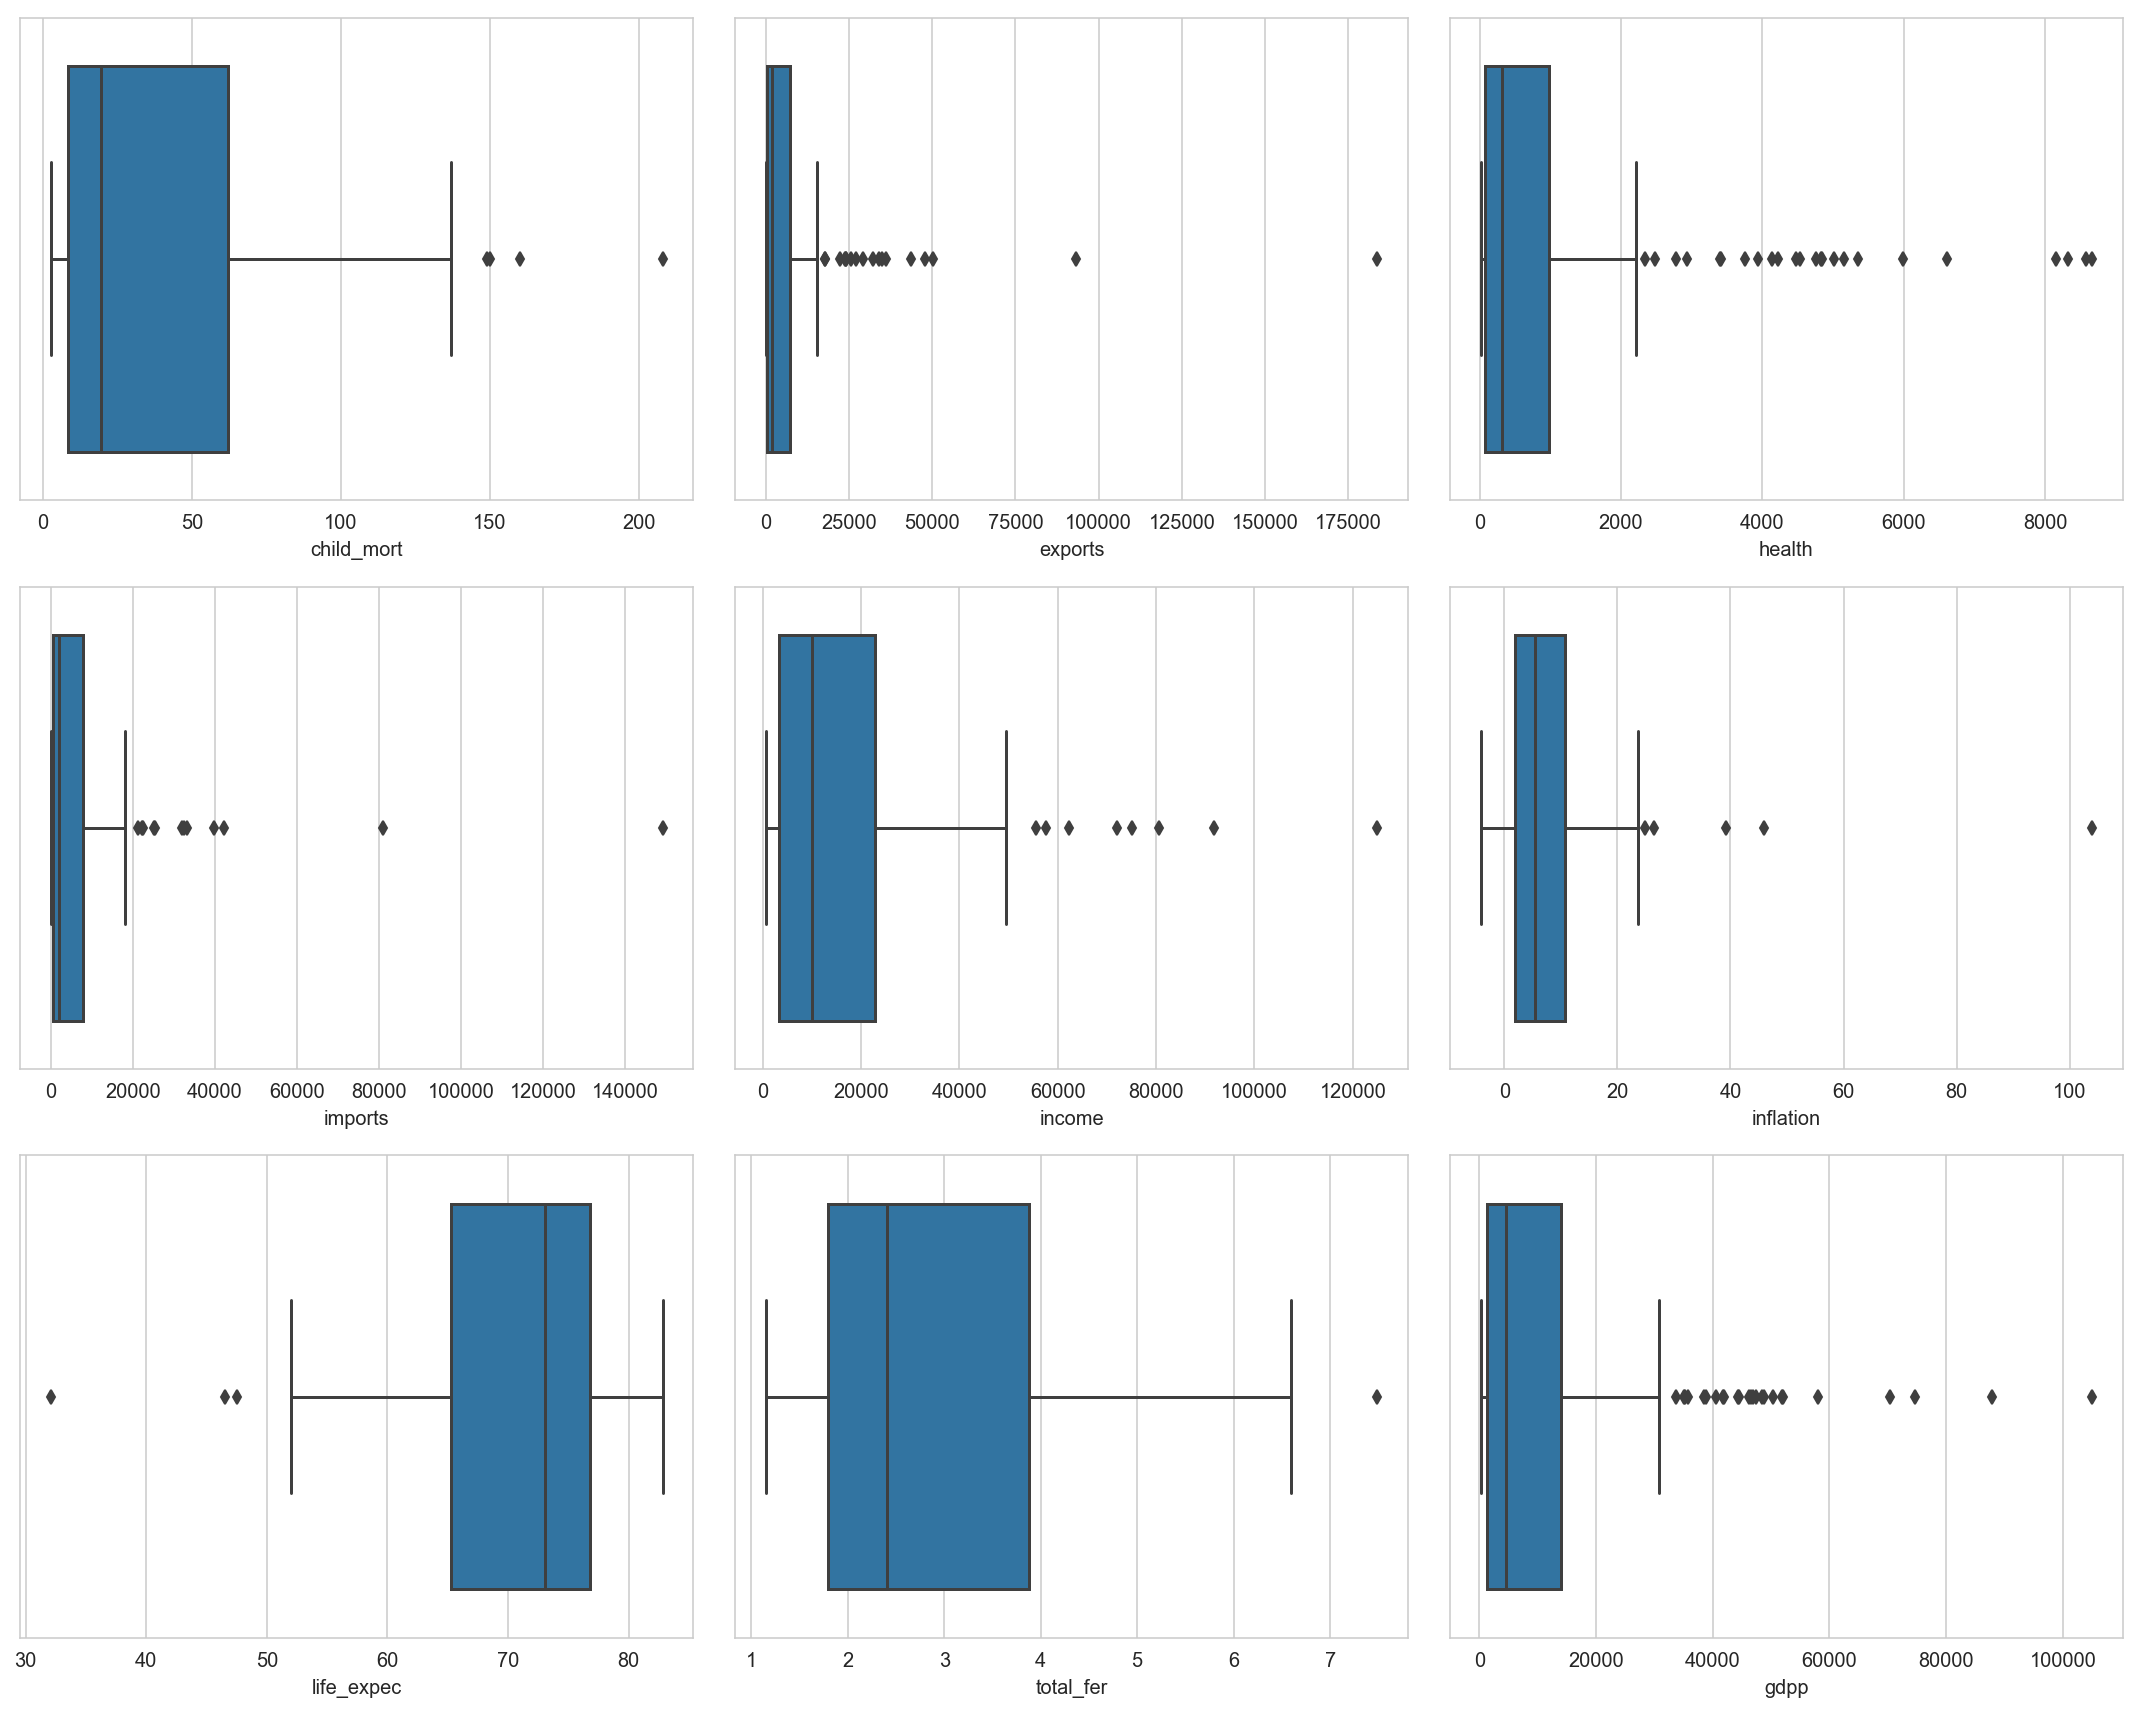

In [16]:
# lets check for data distribution using boxplots
plt.figure(figsize=(15,12))
features = ['child_mort', 'exports', 'health', 'imports', 'income',
            'inflation', 'life_expec', 'total_fer', 'gdpp']

sns.set_style("whitegrid")

for i in enumerate(features):
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(countries[i[1]])

plt.tight_layout()
plt.show()

### Observations from boxplot and distribution plot :

- **child mortality :** we can see clearly that it is right skewed distribution. Some countries have very high child mortality rate.There are some outliers present.
- **exports :** we can see it is a highly right skewed distribution. some countries do very heavy export. There are some outliers present in the data.
- **helath :** Its a right skewed distribution. there are some outliers present in the data.
- **imports :** Its a right skewed distribution. there are some outliers present in the data.
- **income :** Its a right skewed distribution, some outlier countries having high income compare to others.
- **inflation :** its slightly right skewed distributed, but have some outliers. some countries are suffering from very high inflation.
- **life expectancy :** its a left skewed distribution. some countries having very low life expectancy.
- **total fertality :** its a pretty much normally distributed. 
- **GDP per capita :** highly right skewed distribution. with some outliers.

- ### Subtask 2.2 : Bivariate Analysis

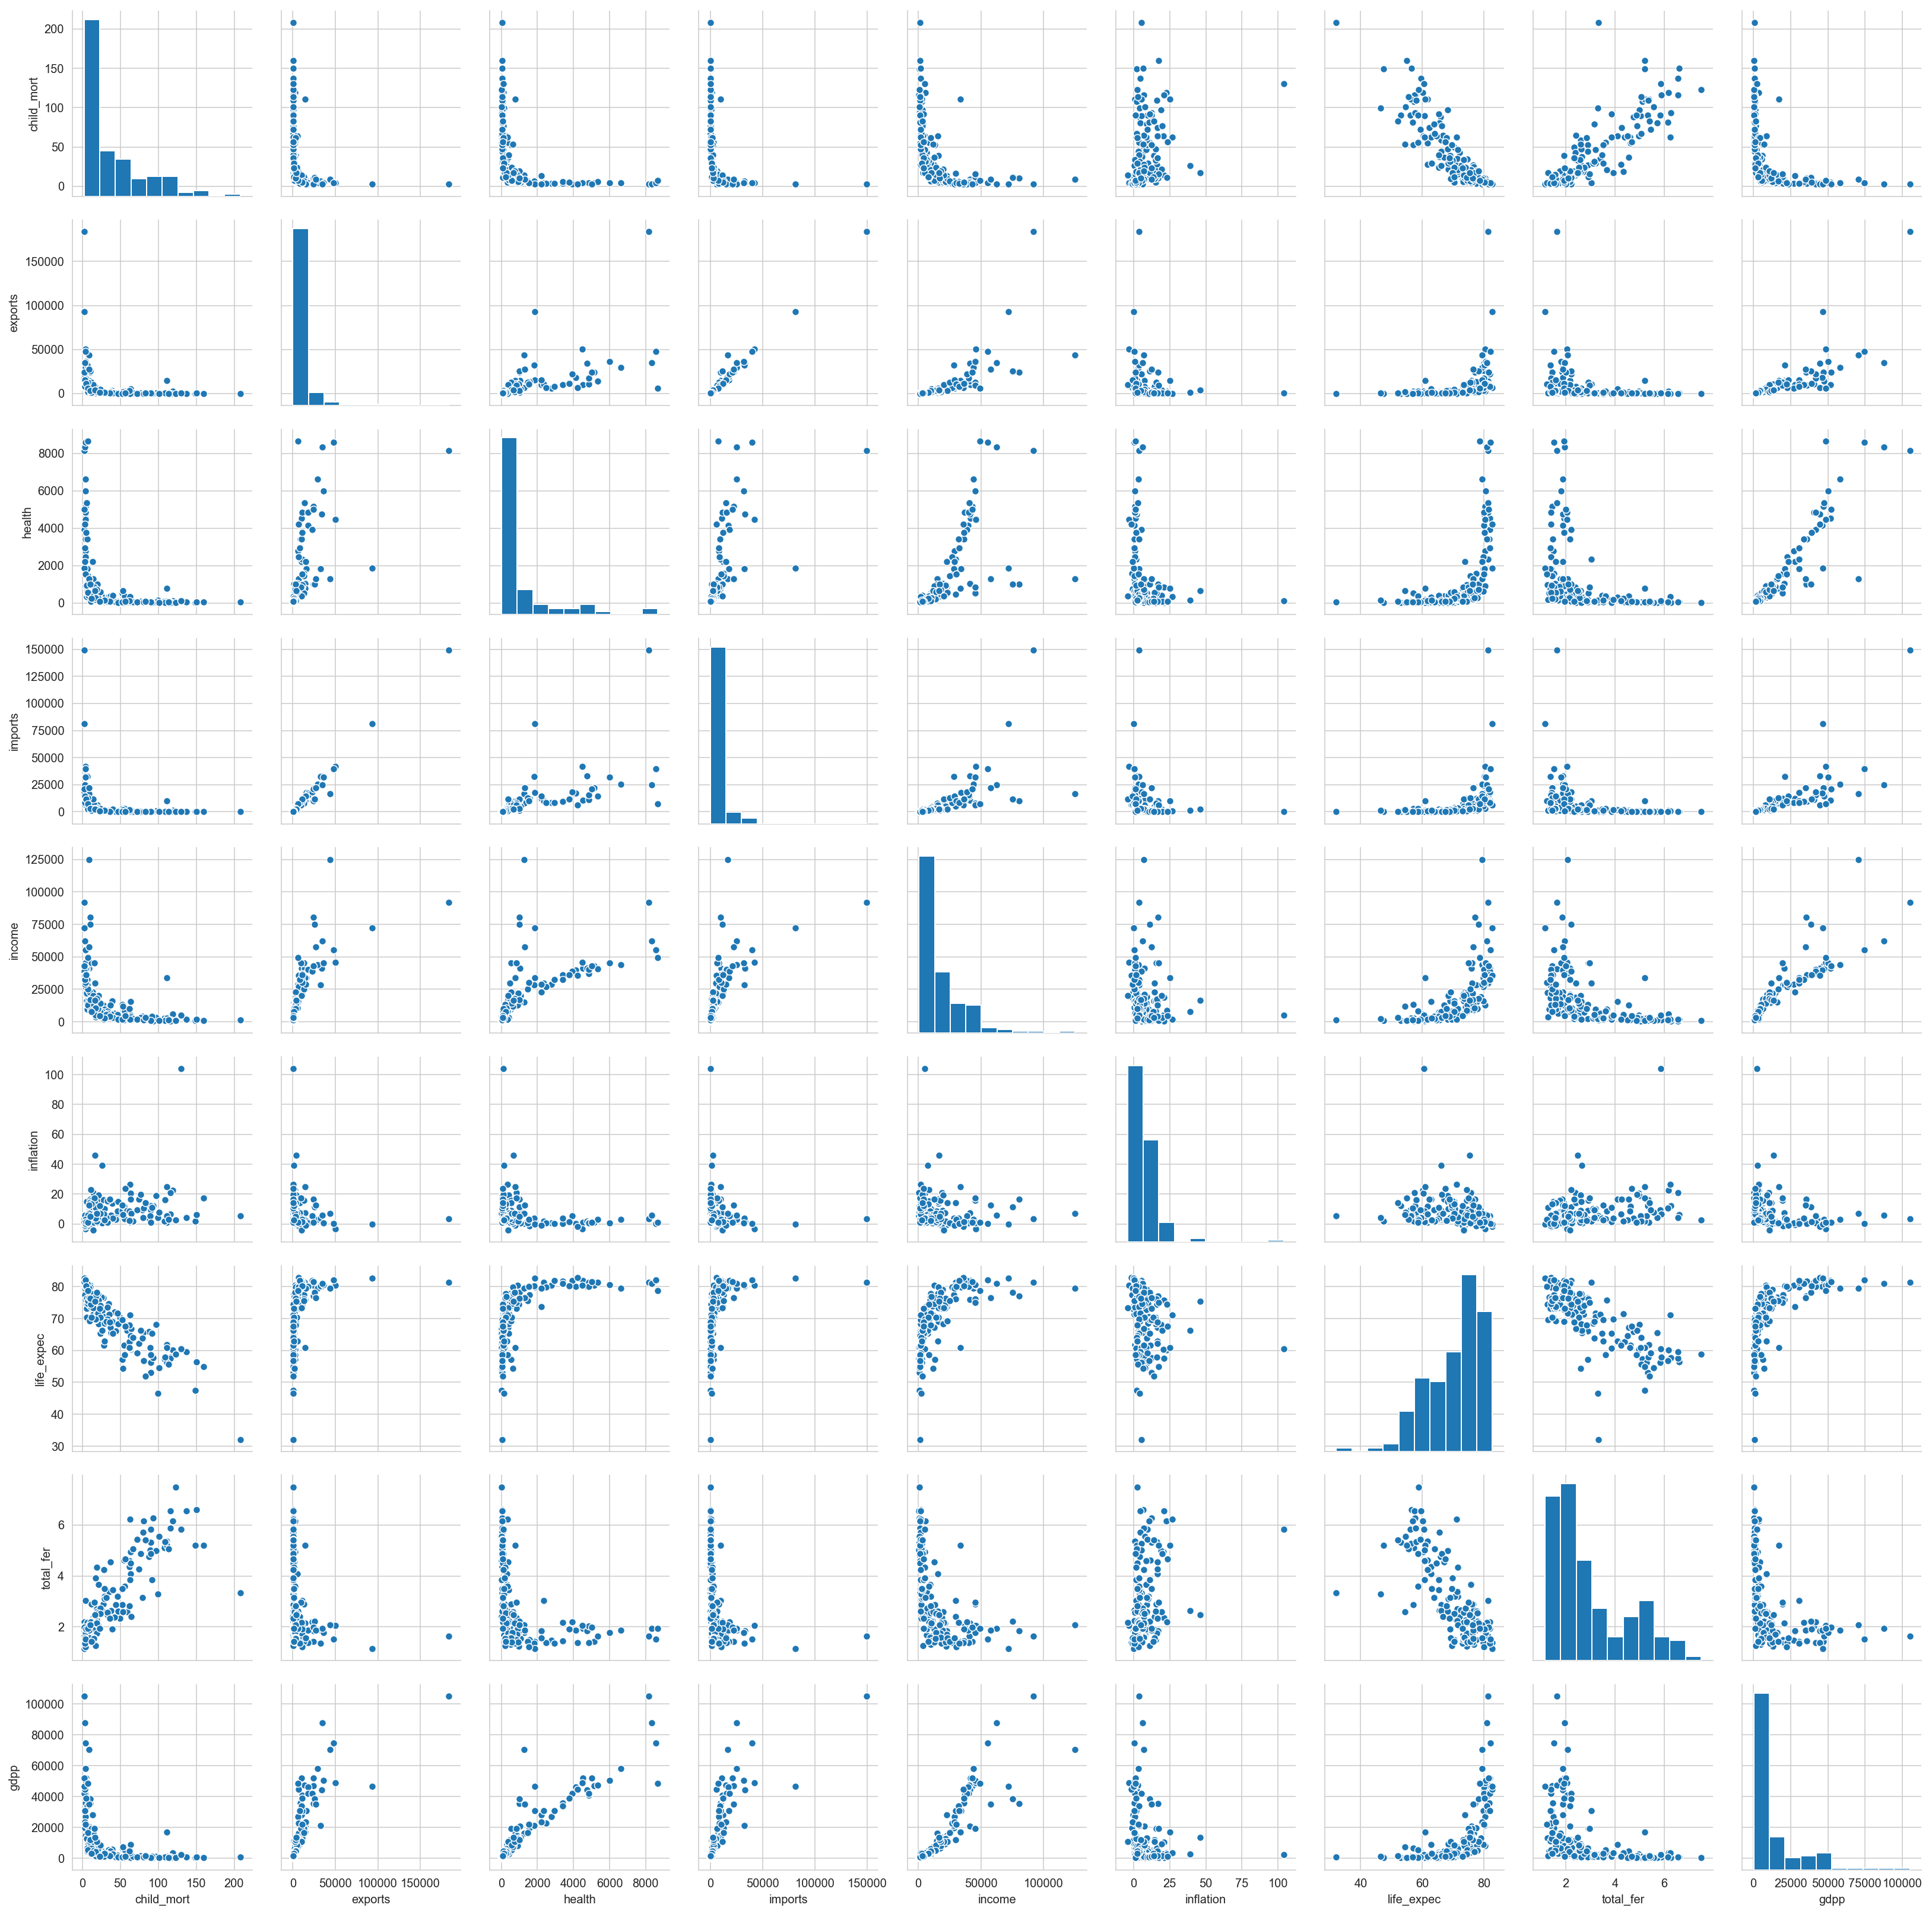

In [17]:
# lets check for pairplots
sns.pairplot(countries)

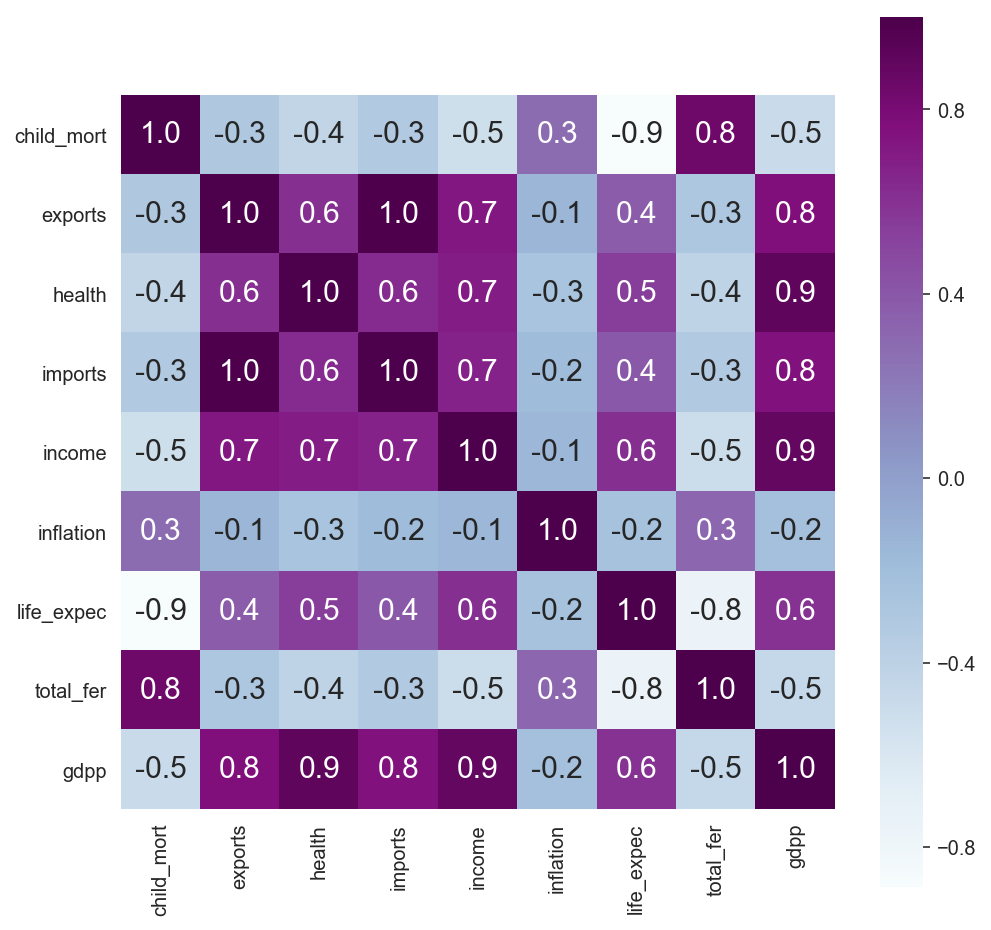

In [19]:
# lets also check for heatmap for better understanding of correlation
cor_matrix = countries.corr()

plt.figure(figsize=(8,8))
sns.heatmap(cor_matrix, cbar=True, square=True, fmt=".1f", 
            annot=True, annot_kws={'size' : 15}, cmap="BuPu")

### Observations from pairplot and Heatmap :

- There is a very high negative trend between child mortality rate and life expectancy. A countries where life expectancy is low, child mortality rate must be pretty high.

- There is high positive trend between child mortality rate and total fertality rate. there are some countries where female give birth to more number of childern and expecting some of them will survive. due to high mortality rate.

- Income having high postive correlation with export, import, health. countries with more income will spend more on helthh, imports and sending more exports.

- Gdp per capita having high positive correlation with export, health, import, income. countries with high gdpp must be developed countries with better socio-economic conditions.



## Task 3 : Data preparation for clustering.

- ### Subtask 3.1 : Outlier detection and treatment

In [20]:
# from the boxplot we plot during EDA we can obscerve, outliers present in the data.
countries.shape

(167, 10)

In [21]:
# since we have only 167 rows and few outliers, we cant afford to lose data.
# so instade of removing an outlier we will go for capping the outliers

# lets check data for different percentile
countries.describe(percentiles=[0.01,0.05,0.25,0.50,0.75,0.95,0.99])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618862,1056.733174,6588.352096,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885789,1801.408921,14710.810423,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.080000,12.820000,0.650000,609.000000,-4.210000,32.100000,1.150000,231.000000
1%,2.800000,22.246800,17.008800,104.911600,742.240000,-2.348800,47.160000,1.243200,331.620000
5%,3.460000,70.470000,26.716000,169.281000,1213.000000,0.183400,55.780000,1.390000,465.900000
25%,8.250000,447.140000,78.535000,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.890000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
95%,116.000000,31385.100000,4966.701000,24241.560000,48290.000000,20.870000,81.400000,5.861000,48610.000000


In [22]:
# lets cap the outliers to 5 - 95 percentile.
# we want to cap the outliers and also we dont want to variation in the data.
# selecting variables having upper outliers lets cap at 95 percentaile
features = ['child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'total_fer', 'gdpp']

#writing a for loop for capping outliers 

for i in features:
    q2 = countries[i].quantile(0.95) # upperlimit is 95 percentile
    
    countries[i][countries[i] >= q2] = q2
    
# for lower outlier lets cap at 5 percentile

q1 = countries["life_expec"].quantile(0.05) # lower limit is 5 percentile

countries["life_expec"][countries["life_expec"] <= q1] = q1

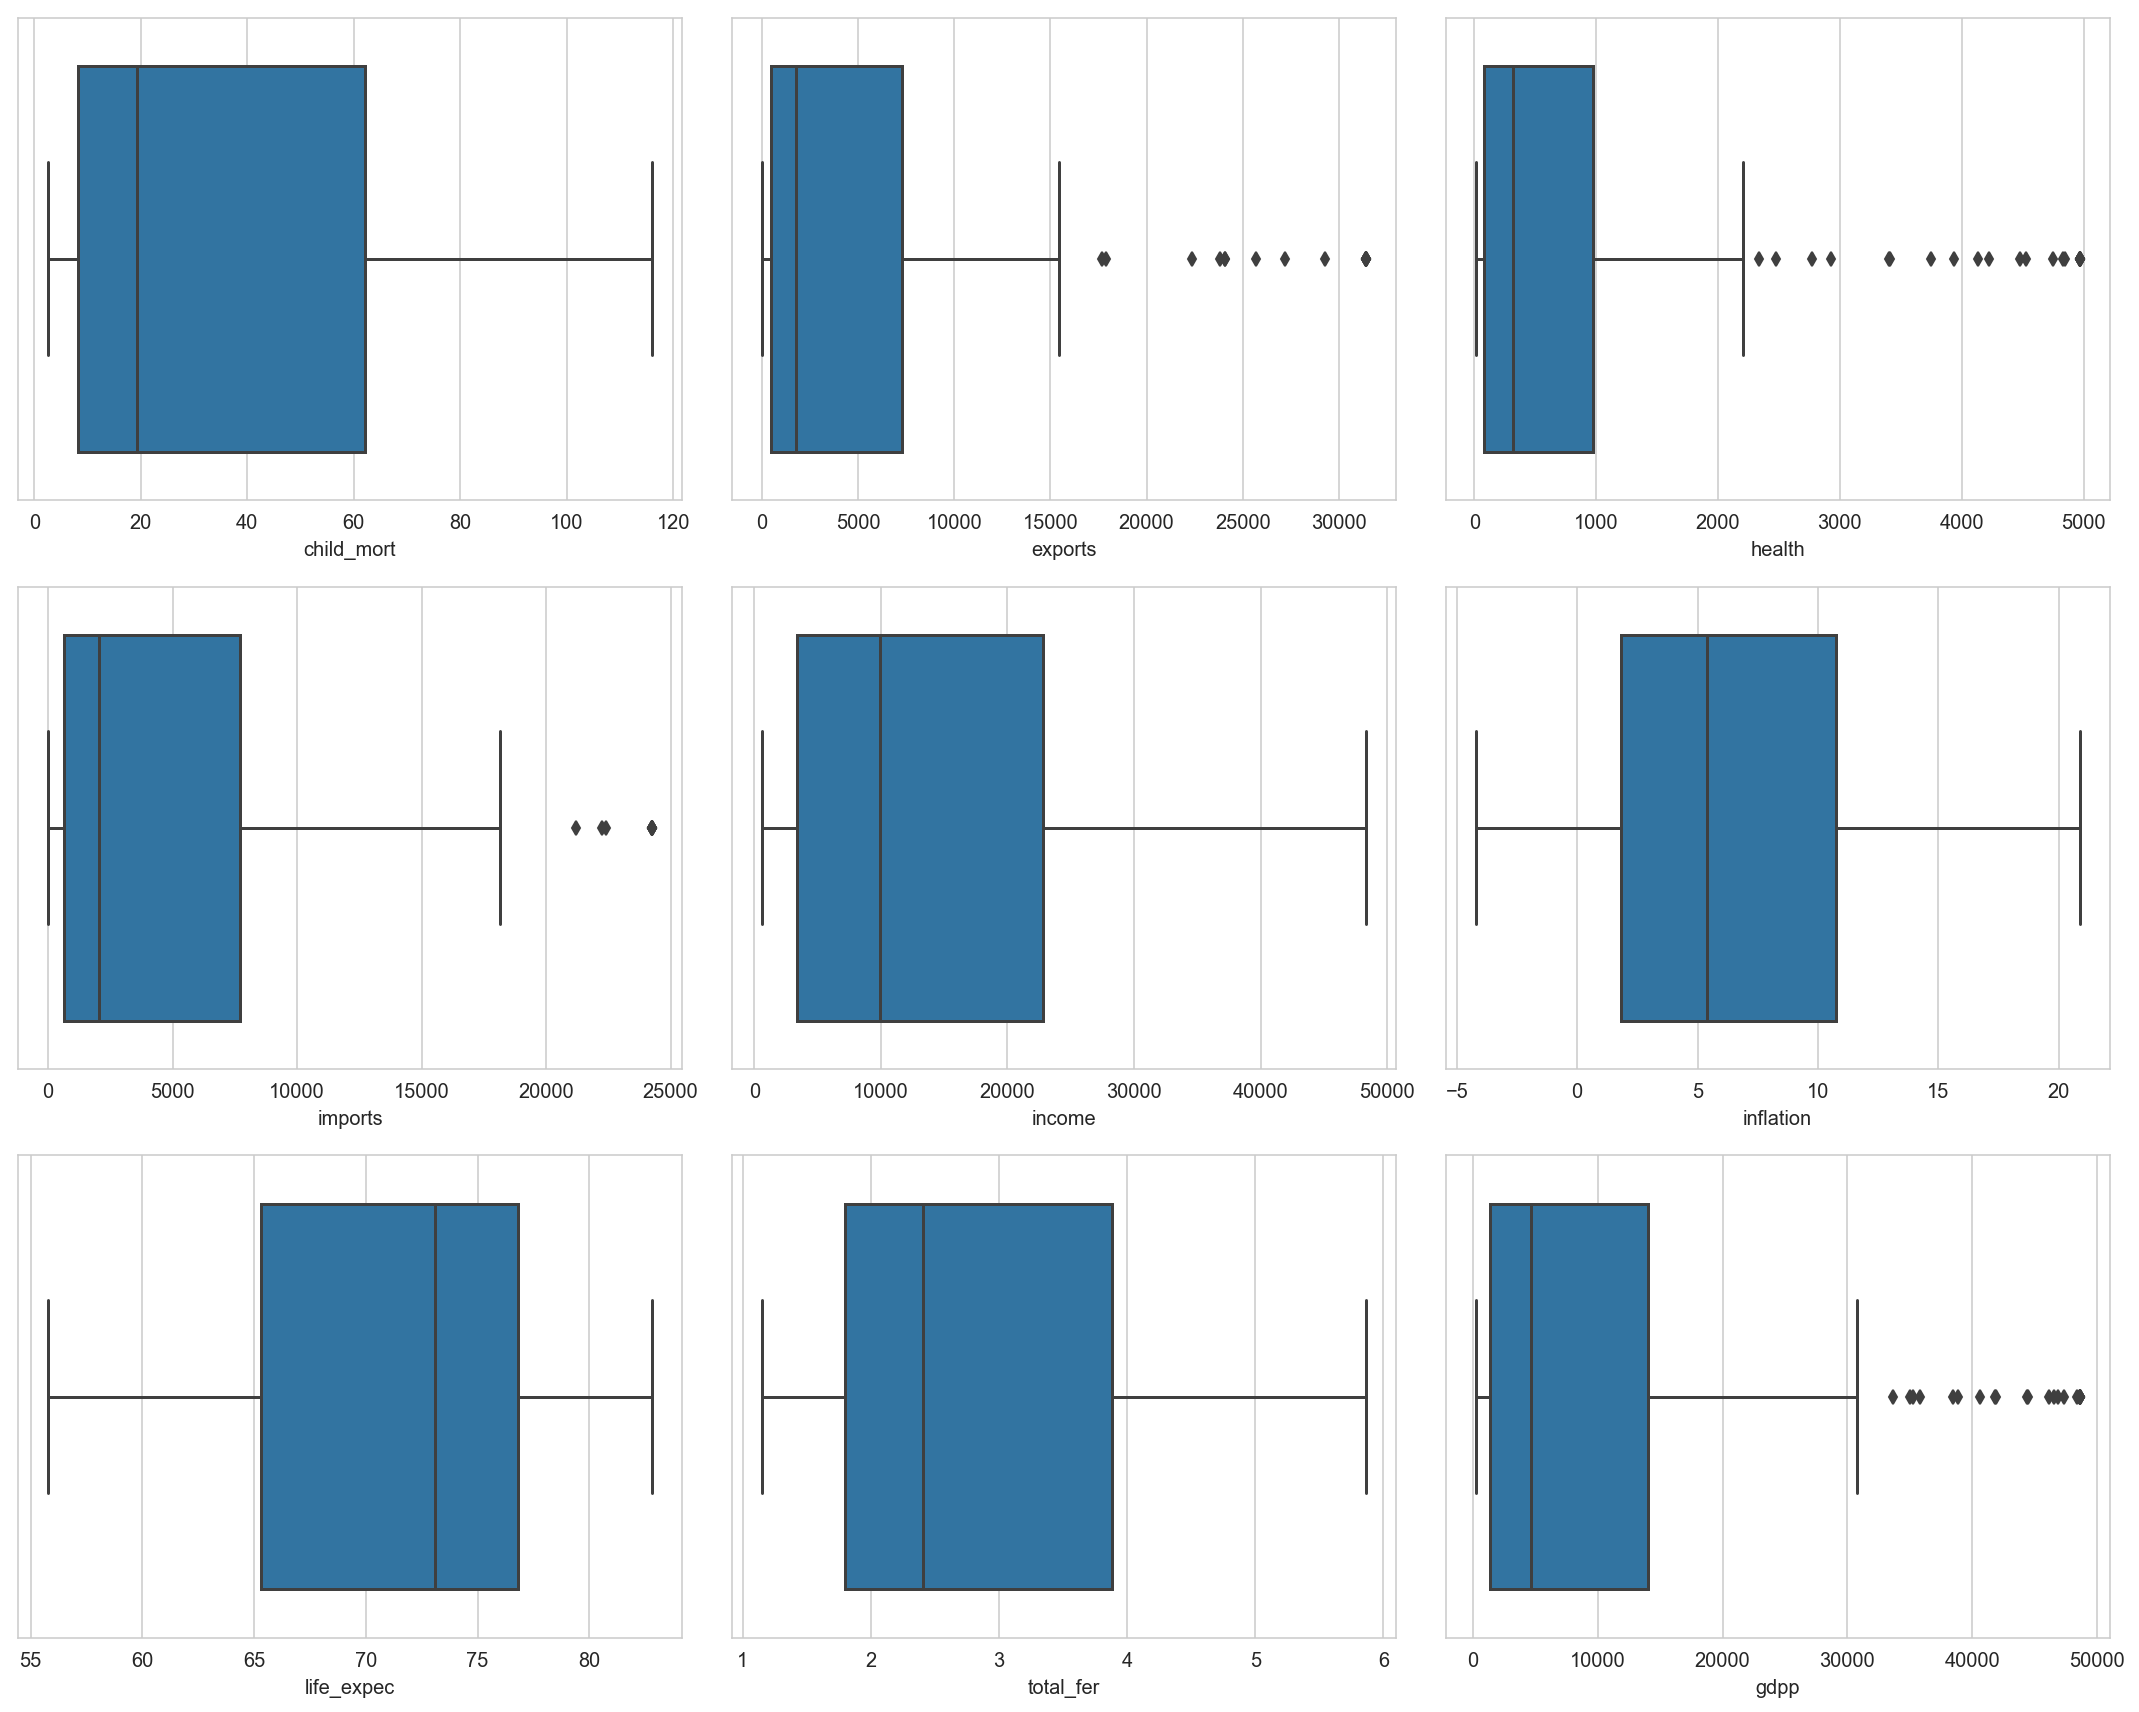

In [23]:
# checking the effect of outlier capping

plt.figure(figsize=(15,12))
features = ['child_mort', 'exports', 'health', 'imports', 'income',
            'inflation', 'life_expec', 'total_fer', 'gdpp']

sns.set_style("whitegrid")

for i in enumerate(features):
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(countries[i[1]])

plt.tight_layout()
plt.show()

distribution of data now look much better than before.

- ### Subtask 3.2 : Scaling Data

In [24]:
countries.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

In [25]:
countries_scaling = countries.copy()  # creating copy for scaling the data

In [26]:
countries_scaling.drop('country',axis=1, inplace=True) # droping country column

In [27]:
scaler = StandardScaler() # creating instance of standardscaler

In [28]:
countries_scaled = scaler.fit_transform(countries_scaling)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



In [29]:
# creating scaled dataframe
countries_scaled = pd.DataFrame(countries_scaled)
countries_scaled.columns = ['child_mort', 'exports', 'health', 'imports', 'income',
                            'inflation', 'life_expec', 'total_fer', 'gdpp']

countries_scaled.head() # checking for changes

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.479341,-0.669581,-0.629434,-0.732728,-0.958349,0.394438,-1.819049,2.016421,-0.757362
1,-0.559029,-0.542172,-0.473485,-0.472182,-0.394006,-0.383226,0.674398,-0.880535,-0.523321
2,-0.262690,-0.475838,-0.530018,-0.560152,-0.192552,1.440750,0.699208,-0.019090,-0.498838
3,2.193878,-0.418960,-0.588939,-0.543087,-0.667360,2.190136,-1.335246,2.044904,-0.560376
4,-0.733509,-0.027134,-0.150685,0.306422,0.227992,-0.862393,0.736424,-0.547072,0.013312


- ### Subtask 3.3 : Hopkins Test

In [30]:
# lets check for cluster tendancy of the data
# function for hopkins test

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [31]:
hopkins(countries_scaled)

0.8219786648790847

**Since hopkins score is more than 0.7, we can say that our data have clustering tendency.**

## Clustering



## Task 4 : K-Means Clustering

- ### Subtask 4.1 : finding optimal number of clusters

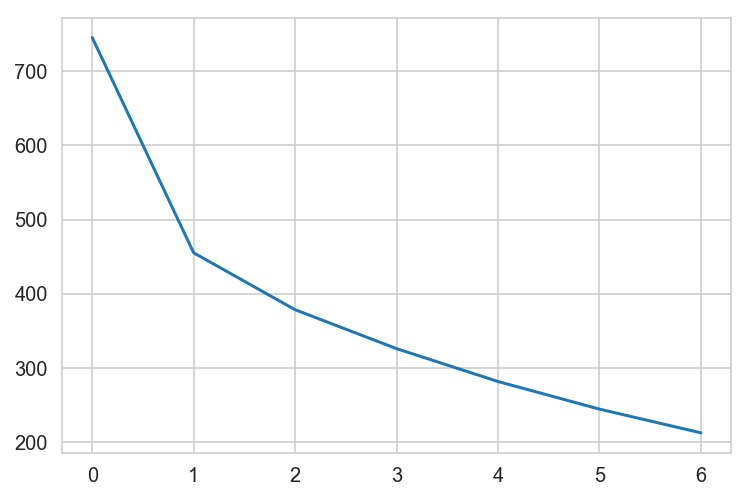

In [32]:
# elbow-curve method

ssd = []
range_n_cluster = [2,3,4,5,6,7,8]

for n in range_n_cluster:
    kmeans = KMeans(n_clusters=n, max_iter=50, random_state=100)
    kmeans.fit(countries_scaled)
    ssd.append(kmeans.inertia_)

# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

x axis in above plot is just a index number

range_n_cluster = 2,3,4,5,6,7,8 in above graph 0=2, 1=3, etc.

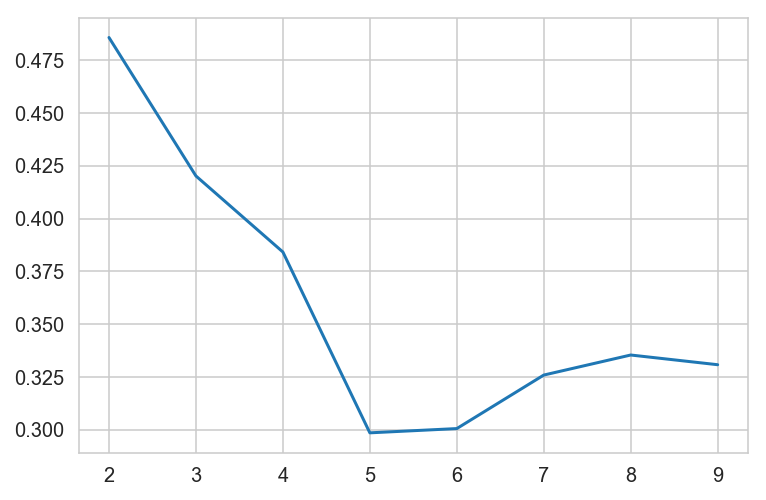

In [33]:
# silhouette analysis
from sklearn.metrics import silhouette_score
ss = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters = k,max_iter=100, random_state=100).fit(countries_scaled)
    ss.append([k, silhouette_score(countries_scaled, kmeans.labels_)])
    
plt.plot(pd.DataFrame(ss)[0], pd.DataFrame(ss)[1])

In [34]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=100, random_state=100)
    kmeans.fit(countries_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(countries_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.4856761567903262
For n_clusters=3, the silhouette score is 0.42014564656187364
For n_clusters=4, the silhouette score is 0.38415028263222717
For n_clusters=5, the silhouette score is 0.2985654140264333
For n_clusters=6, the silhouette score is 0.30058214790814997
For n_clusters=7, the silhouette score is 0.3259061928055558
For n_clusters=8, the silhouette score is 0.3353967441625899


- from elbow curve we can see it is suggesting 3 cluster as optimal value since after 3 slope is decreasing at less rate compare to previous 3 cluster. we can see elbow at 3.


- average silhouette score for 2 cluster is high, but average silhouette score difference between 2 and 3 is not that big, 3 cluster can also give good quality clusters.

**lets choose 3 clusters for further analysis.**

- ### Subtask 4.2 : running K-Means with 3 clusters

In [35]:
# with 3 cluster k-means
kmeans = KMeans(n_clusters=3, max_iter=100, random_state = 100)
kmeans.fit(countries_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=100, tol=0.0001, verbose=0)

In [36]:
kmeans.labels_

array([2, 1, 1, 2, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 2,
       1, 0, 1, 2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 0, 0,
       0, 1, 1, 1, 1, 2, 2, 1, 1, 0, 0, 2, 2, 1, 0, 2, 0, 1, 1, 2, 2, 1,
       2, 1, 0, 1, 1, 1, 2, 0, 0, 0, 1, 0, 1, 1, 2, 2, 0, 1, 2, 1, 1, 2,
       2, 1, 1, 0, 1, 2, 2, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
       0, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 2, 1, 1,
       2, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 1, 0, 0, 1, 2, 1, 2, 2, 1, 1, 1,
       1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2])

In [37]:
# assigining the labels to perticular data point
countries["cluster_id"] = kmeans.labels_
countries.head() # checking for changes

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.92,248.30,1610.0,9.44,56.2,5.820,553,2
1,Albania,16.6,1145.20,267.90,1987.74,9930.0,4.49,76.3,1.650,4090,1
2,Algeria,27.3,1712.64,185.98,1400.44,12900.0,16.10,76.5,2.890,4460,1
3,Angola,116.0,2199.19,100.60,1514.37,5900.0,20.87,60.1,5.861,3530,2
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100.0,1.44,76.8,2.130,12200,1


In [38]:
# changing data type of cluster_id for further analysis
countries["cluster_id"] = countries.cluster_id.apply(str)

In [39]:
countries.info() # checking for changes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 11 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null float64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
cluster_id    167 non-null object
dtypes: float64(8), int64(1), object(2)
memory usage: 14.4+ KB


- ### Subtask 4.3 : Cluster Profiling

In [40]:
# counting how much data points assigned to each cluster
countries["cluster_id"].value_counts()

1    82
2    48
0    37
Name: cluster_id, dtype: int64

From above distribution of datapoints to cluster, we can see they are not equally distributed but it is a fair enough distribution. so no unnecessary clusters present.

In [50]:
# lets visualize the clusters 
# GDP per capita vs Child mortality rate
px.scatter(countries, x="child_mort", y="gdpp", hover_name="country", color="cluster_id", 
           width=700, height=400, template="plotly", 
           labels={"child_mort":"Child Mortality Rate", "gdpp":"GDP per capita"},
           title="GDP per capita vs Child Mortality Rate")

#### Observation:

- **cluster 1 :** countries with medium level or average level of GDP per capita and medium or average level of Child mortality rate.

- **cluster 0 :** countries with very high GDP per capita and very low Child Mortality Rate.

- **cluster 2 :** countries with very low GDP per capita and very high Child Mortality Rate.

In [42]:
# GDP per capita vs Income 
px.scatter(countries, x="income", y="gdpp", hover_name="country", color="cluster_id", 
           width=700, height=400, template='seaborn', 
           labels={"income":"Income", "gdpp":"GDP per capita"},
           title="GDP per capita vs Income")

**we can see here cluster 1 and cluster 2 are overlaping. but cluster 2 looks better in comparision with cluster 1 in both GDP per capita and Income terms.**


**cluster 0 is clearly looks most better with High GDP per capita and High Income in comparision with cluster 1 and cluster 2.**

In [43]:
# lets check for Income vs Child Mortality Rate
px.scatter(countries, x="child_mort", y="income", hover_name="country", color="cluster_id", 
           width=700, height=400, template='gridon', 
           labels={"income":"Income", "child_mort":"Child Mortality Rate"},
           title="Child Mortality Rate vs Income")

#### Observation:

- **cluster 2 :** countries with medium level or average level of Income and medium or average level of Child mortality rate.

- **cluster 0 :** countries with very high Income and very low Child Mortality Rate.

- **cluster 1:** countries with very low Income and very high Child Mortality Rate.

In [44]:
cluster_analysis = countries[["gdpp","child_mort","income","cluster_id"]].groupby("cluster_id").mean()

In [45]:
cluster_analysis # Centroid location for each clusters

,gdpp,child_mort,income
cluster_id,,,
0,37745.675676,5.237838,38711.081081
1,6287.463415,21.951220,12304.756098
2,1909.208333,86.443750,3897.354167


In [49]:
px.bar(cluster_analysis,log_y=True, barmode='group',height=450,width=700, template='plotly')

#### Observation:

- **cluster 2 :** countries with moderate level of GDP per capita ,moderate level of Child mortality rate and moderate level of Income 

- **cluster 0 :** countries with very high GDP per capita, very low Child Mortality Rate and very high income.

- **cluster 1 :** countries with very low GDP per capita, very high Child Mortality Rate and very low income.

countries in cluster 0 shows the characteristics Developed Countries
 & countries in cluster 2 shows the characteristics Developing Countries
& countries in cluster 1 shows the characteristics Underdeveloped Countries.

**Cluster 0 : Developed countries**

**Cluster 1 : Underdeveloped Countries**

**Cluster 2 : Developing countries**

As given in the problem statement we need to find out countries who are in direst need of the aid, based on socio-economic conditions, so that HELP International can use its fund trategically and effectively.

as per our findings, countries in cluster 1 are under devloped countries who have a bad socio-economic conditions. now lets find out countires from cluster 1 who are in direst need.

In [51]:
# seperate out under developed countries
underdeveloped = countries[countries["cluster_id"] == "1"]
underdeveloped.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
1,Albania,16.6,1145.20,267.90,1987.74,9930.0,4.49,76.3,1.65,4090,1
2,Algeria,27.3,1712.64,185.98,1400.44,12900.0,16.10,76.5,2.89,4460,1
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100.0,1.44,76.8,2.13,12200,1
5,Argentina,14.5,1946.70,834.30,1648.00,18700.0,20.87,75.8,2.37,10300,1
6,Armenia,18.1,669.76,141.68,1458.66,6700.0,7.77,73.3,1.69,3220,1


In [52]:
# lets find top 10 countries who are in direst needs
needy_countries=underdeveloped.sort_values(by = ['gdpp','child_mort','income'],
                                           ascending=[True,False,True]).head(10)

In [53]:
needy_countries

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
109,Nepal,47.0,56.71,31.08,215.49,1990.0,15.10,68.3,2.61,592,1
146,Tajikistan,52.4,109.96,44.13,432.47,2110.0,12.50,69.6,3.51,738,1
12,Bangladesh,49.4,121.28,26.68,165.24,2440.0,7.14,70.4,2.33,758,1
27,Cambodia,44.4,425.23,44.64,467.67,2520.0,3.12,66.1,2.88,786,1
83,Kyrgyz Republic,29.6,454.08,54.38,718.96,2790.0,10.00,68.5,3.10,880,1
107,Myanmar,64.4,1.08,19.46,0.65,3720.0,7.04,66.8,2.41,988,1
164,Vietnam,23.3,943.20,89.60,1050.62,4490.0,12.10,73.1,1.95,1310,1
69,India,58.8,305.10,54.68,365.85,4410.0,8.98,66.2,2.60,1350,1
161,Uzbekistan,36.3,437.46,80.18,393.30,4240.0,16.50,68.8,2.34,1380,1
102,Moldova,17.2,638.96,190.71,1279.55,3910.0,11.10,69.7,1.27,1630,1


As per the K-means algorithm, countries which are in dierst need are as follow :
1. Burundi
2. Liberia
3. Congo, Dem. Rep.
4. Niger
5. Sierra Leone
6. Madagascar
7. Mozambique
8. Central African Republic
9. Malawi
10. Eritrea

## Task 5 : Hierarchical Clustering

- ### Subtask 5.1 : using single linkage and complete linkage

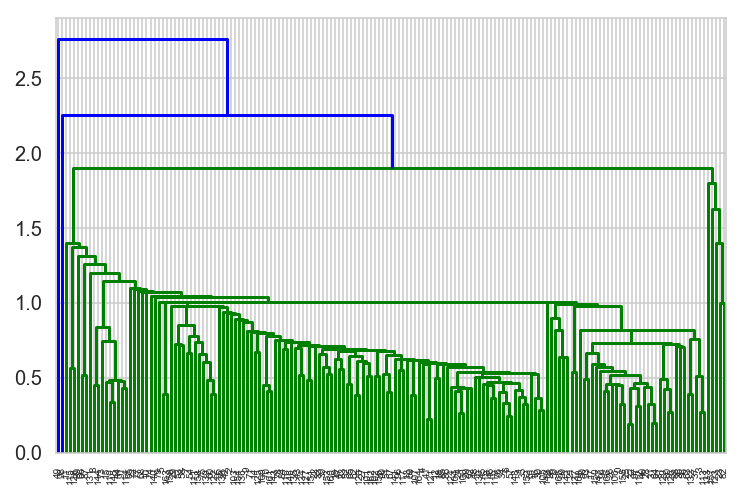

In [54]:
# using single linkage
h_clusters = linkage(countries_scaled, method='single', metric="euclidean")
dendrogram(h_clusters)
plt.show()

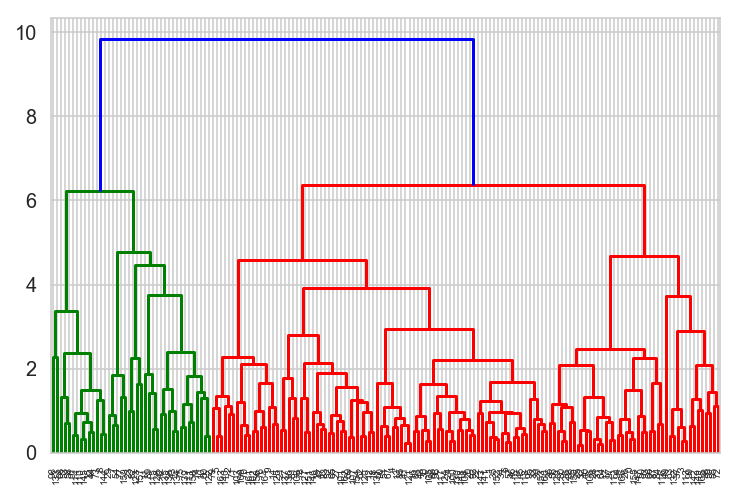

In [55]:
# using complete linkage
h_clusters = linkage(countries_scaled, method='complete', metric='euclidean')
dendrogram(h_clusters)
plt.show()

from dendrogram of single linkage and complete linkage, we can see complete linkage clearly have done a great job. 

dendrogram with complete linkage suggesting for 2 cluster, but 3 cluster is making more sense to divide countries in 3 groups, to find most needy countries.

In [56]:
# lets cut the tree at 3 clusters
cluster_labels = cut_tree(h_clusters, n_clusters=3).reshape(-1,)

In [57]:
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 2,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1,
       0, 1, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 0, 1, 2, 1, 0, 1, 1, 0,
       0, 2, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       2, 2, 0, 0, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 0, 1, 1,
       0, 2, 2, 2, 1, 1, 2, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0])

In [58]:
# assign cluser labels to data
countries["cluster_labels"] = cluster_labels

In [59]:
countries.head() # checking for changes

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
0,Afghanistan,90.2,55.30,41.92,248.30,1610.0,9.44,56.2,5.820,553,2,0
1,Albania,16.6,1145.20,267.90,1987.74,9930.0,4.49,76.3,1.650,4090,1,1
2,Algeria,27.3,1712.64,185.98,1400.44,12900.0,16.10,76.5,2.890,4460,1,1
3,Angola,116.0,2199.19,100.60,1514.37,5900.0,20.87,60.1,5.861,3530,2,0
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100.0,1.44,76.8,2.130,12200,1,1


In [60]:
# changing data type of cluster labels to object for further analysis.
countries["cluster_labels"] = countries["cluster_labels"].apply(str)

In [61]:
countries["cluster_labels"].dtypes # checking for changes

dtype('O')

- ### Subtask 5.2 : Cluster Profiling

In [62]:
countries["cluster_labels"].value_counts()

1    84
0    43
2    40
Name: cluster_labels, dtype: int64

From above distribution of datapoints to cluster, we can see they are not equally distributed but it is a fair enough distribution. so no unnecessary clusters present.

In [64]:
# lets visualize the clusters 
# GDP per capita vs Child mortality rate
px.scatter(countries, x="child_mort", y="gdpp", hover_name="country", color="cluster_labels", 
           width=700, height=400, template="ggplot2", 
           labels={"child_mort":"Child Mortality Rate", "gdpp":"GDP per capita"},
           title="GDP per capita vs Child Mortality Rate")

#### Observation:

- **cluster 1 :** countries with medium level or average level of GDP per capita and medium or average level of Child mortality rate.

- **cluster 2 :** countries with very high GDP per capita and very low Child Mortality Rate.

- **cluster 0 :** countries with very low GDP per capita and very high Child Mortality Rate.

In [65]:
# GDP per capita vs Income 
px.scatter(countries, x="income", y="gdpp", hover_name="country", color="cluster_labels", 
           width=700, height=400, template="seaborn", 
           labels={"income":"Income", "gdpp":"GDP per capita"},
           title="GDP per capita vs Income")

**we can see here cluster 1 and cluster 0 are overlaping. but cluster 1 looks better in comparision with cluster 0 in both GDP per capita and Income terms.**


**cluster 2 is clearly looks most better with High GDP per capita and High Income in comparision with cluster 0 and cluster 1.**

In [66]:
# lets check for Income vs Child Mortality Rate
px.scatter(countries, x="child_mort", y="income", hover_name="country", color="cluster_labels", 
           width=700, height=400, template="plotly", 
           labels={"income":"Income", "child_mort":"Child Mortality Rate"},
           title="Child Mortality Rate vs Income")

#### Observation:

- **cluster 1 :** countries with medium level or average level of Income and medium or average level of Child mortality rate.

- **cluster 2 :** countries with very high Income and very low Child Mortality Rate.

- **cluster 0:** countries with very low Income and very high Child Mortality Rate.

In [67]:
cluster_analysis = countries[["gdpp","child_mort","income","cluster_labels"]].groupby("cluster_labels").mean()

In [68]:
cluster_analysis # Centroid location for each clusters

,gdpp,child_mort,income
cluster_labels,,,
0,1628.883721,90.611628,3483.790698
1,5791.333333,23.916667,11023.333333
2,36182.250000,5.945000,38815.250000


In [69]:
px.bar(cluster_analysis,log_y=True, barmode='group',height=450,width=700, template="simple_white")

#### Observation:

- **cluster 1 :** countries with moderate level of GDP per capita ,moderate level of Child mortality rate and moderate level of Income 

- **cluster 2 :** countries with very high GDP per capita, very low Child Mortality Rate and very high income.

- **cluster 0 :** countries with very low GDP per capita, very high Child Mortality Rate and very low income.

**Cluster 2 : Developed countries**

**Cluster 0 : Underdeveloped Countries**

**Cluster 1 : Developing countries**

As given in the problem statement we need to find out countries who are in direst need of the aid, based on socio-economic conditions, so that HELP International can use its fund trategically and effectively.

as per our findings, countries in cluster 0 are underdevloped countries who have a bad socio-economic conditions. now lets find out countires from cluster 1 who are in direst need.

In [70]:
# seperate out under developed countries
underdeveloped = countries[countries["cluster_labels"] == "0"]
underdeveloped.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
0,Afghanistan,90.2,55.30,41.92,248.30,1610.0,9.440,56.2,5.820,553,2,0
3,Angola,116.0,2199.19,100.60,1514.37,5900.0,20.870,60.1,5.861,3530,2,0
17,Benin,111.0,180.40,31.08,281.98,1820.0,0.885,61.8,5.360,758,2,0
25,Burkina Faso,116.0,110.40,38.76,170.20,1430.0,6.810,57.9,5.861,575,2,0
26,Burundi,93.6,20.61,26.80,90.55,764.0,12.300,57.7,5.861,231,2,0


In [71]:
# lets find top 10 countries who are in direst needs
needy_countries=underdeveloped.sort_values(by = ['gdpp','child_mort','income'],
                                           ascending=[True,False,True]).head(10)

In [72]:
needy_countries

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
26,Burundi,93.6,20.61,26.80,90.55,764.0,12.30,57.70,5.861,231,2,0
88,Liberia,89.3,62.46,38.59,302.80,700.0,5.47,60.80,5.020,327,2,0
37,"Congo, Dem. Rep.",116.0,137.27,26.42,165.66,609.0,20.80,57.50,5.861,334,2,0
112,Niger,116.0,77.26,17.96,170.87,814.0,2.55,58.80,5.861,348,2,0
132,Sierra Leone,116.0,67.03,52.27,137.66,1220.0,17.20,55.78,5.200,399,2,0
93,Madagascar,62.2,103.25,15.57,177.59,1390.0,8.79,60.80,4.600,413,2,0
106,Mozambique,101.0,131.99,21.83,193.58,918.0,7.64,55.78,5.560,419,2,0
31,Central African Republic,116.0,52.63,17.75,118.19,888.0,2.01,55.78,5.210,446,2,0
94,Malawi,90.5,104.65,30.25,160.19,1030.0,12.10,55.78,5.310,459,2,0
50,Eritrea,55.2,23.09,12.82,112.31,1420.0,11.60,61.70,4.610,482,2,0


As per the Hierarchical Clustering algorithm, countries which are in dierst need are as follow :
1. Burundi
2. Liberia
3. Congo, Dem. Rep.
4. Niger
5. Sierra Leone
6. Madagascar
7. Mozambique
8. Central African Republic
9. Malawi
10. Eritrea

## Task 6 : Country Identification

we choose top 10 countries by using both k-means algorithm and Hierarchical Clustering algorithm and we got exact same result. 

here first identify the cluster of underdeveloped countries, then based on GDP percapita, child mortality rate and net income per person we indentify 10 countries.

- lowest gdp per capita among underdeveloped countries means, these countries are really poor.


- high child mortality rate means, healthcare structure of these countries is in very bad state, maybe here child under age 5, where its immunity system is not  developed yet did not have acces to diiferent vaccination.


- low net income per person means, person do not have enough income to spend for its own betterment and since the gdp per capita is also low thats why government also not able to spend on its people.


- we can also observe that selected countries in the final list, all of them are African countries.

Based on these criteria we choose follwing countries : 

1. Burundi

2. Liberia

3. Congo, Dem. Rep.

4. Niger

5. Sierra Leone

6. Madagascar

7. Mozambique

8. Central African Republic

9. Malawi

10. Eritrea